# 实测技术分析

## 本段代码利用quantOS系统分析了几个常见技术信号有效性，我们选取了两个技术形态：三根阳
## 线，金叉死叉，以及一个技术指标：跳空高开。大致步骤如下：
## 1. 首先通过`add_formula`功能将信号用公式表达并计算，再加入到`DataView`中
## 2. 利用信号测试模块`jaqs.research.SignalDigger`分析信号有效性

## 1. 准备工作

### 1.1 设置参数

In [1]:
from __future__ import unicode_literals

import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
import pandas as pd

import seaborn as sns

from jaqs.data import DataView
from jaqs.data import RemoteDataService
from jaqs.research import SignalDigger
import jaqs.util as jutil

/home/bliu/pytrade_dir/venv_pytrade/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# 设置服务器地址、用户名密码

phone = 'YourPhoneNumber'
token = 'YourToken'

data_config = {
  "timeout": 1800,
  "remote.data.address": "tcp://data.tushare.org:8910",
  "remote.data.username":  phone,
  "remote.data.password":  token}

dataview_folder = 'technical_analysis'

### 1.2 初始化DataView

In [12]:
# 选股范围和基准设为沪深300指数
ds = RemoteDataService()
ds.init_from_config(data_config)
dv = DataView()

props = {'start_date': 20130101, 'end_date': 20171031, 'universe': '000300.SH',
         'fields': 'volume,turnover',
         'freq': 1}

dv.init_from_config(props, ds)
dv.prepare_data()

dv.save_dataview(dataview_folder)


Begin: DataApi login 17321165656@tcp://data.tushare.org:8910
    login success 

Initialize config success.
Query data...
Query data - query...
NOTE: price adjust method is [post adjust]
Query data - daily fields prepared.
Query instrument info...
Query adj_factor...
Query benchmark...
Query benchmar member info...
Data has been successfully prepared.

Store data...
Dataview has been successfully saved to:
/home/bliu/pytrade_dir/ipynb/xyyang/technical_analysis

You can load it with load_dataview('/home/bliu/pytrade_dir/ipynb/xyyang/technical_analysis')


### 1.3 检查股票是否出现停牌、调处成份股和达到涨跌幅限制的情况，分析时将会过滤掉

In [4]:
# 判断个股当前是否达到涨跌停限制：达到 = True， 未达到 = False
dv.add_formula('mask_limit_reached', 'Abs((open - Delay(close, 1)) / Delay(close, 1)) > 0.095', is_quarterly=False)

# 判断个股当期是否为成份股：是成份股 = True， 非成份股 = False
dv.add_formula('mask_index_member', '(index_member == 0)', is_quarterly=False)

# 判断个股当前是否处于停牌状态
trade_status = dv.get_ts('trade_status')
mask_sus = trade_status == u'停牌'
dv.append_df(mask_sus, 'mask_sus', is_quarterly=False)

/home/bliu/pytrade_dir/jaqs/jaqs/data/py_expression_eval.py:420: RuntimeWarning: invalid value encountered in greater
  res = arr > brr


In [5]:
# 将以上三个条件整合
mask_limit_reached = dv.get_ts('mask_limit_reached')
mask_index_member = dv.get_ts('mask_index_member')
mask_sus = dv.get_ts('mask_sus')
mask_all = np.logical_or(mask_sus, np.logical_or(mask_index_member, mask_limit_reached))

## 取出股价序列和指数价格序列 用于计算超额收益
这里使用后复权价格

In [6]:
price = dv.get_ts('close_adj')
price_bench = dv.data_benchmark

## 2. 技术指标一：金叉死叉 

### 2.1 定义金叉死叉，并通过add_formula添加到dataview中

In [7]:
# 定义快速均线(5天)和慢速均线(15天)
dv.add_formula('fast_MA', 'Ts_Mean(close_adj, 5)', is_quarterly=False)
dv.add_formula('slow_MA', 'Ts_Mean(close_adj, 15)', is_quarterly=False)

# 定义金叉
factor_formula = '(Delay(fast_MA, 1) < Delay(slow_MA, 1) ) && (fast_MA > slow_MA)'
dv.add_formula('golden_cross', factor_formula, is_quarterly=False)

# 定义死叉
factor_formula = '(Delay(fast_MA, 1) > Delay(slow_MA, 1) ) && (fast_MA < slow_MA)'
dv.add_formula('dark_cross', factor_formula, is_quarterly=False)

/home/bliu/pytrade_dir/jaqs/jaqs/data/py_expression_eval.py:556: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False).mean()
  return pd.rolling_mean(x, n)
/home/bliu/pytrade_dir/jaqs/jaqs/data/py_expression_eval.py:556: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=15,center=False).mean()
  return pd.rolling_mean(x, n)
/home/bliu/pytrade_dir/jaqs/jaqs/data/py_expression_eval.py:429: RuntimeWarning: invalid value encountered in less
  res = arr < brr


### 2.2 分析死叉信号

Nan Data Count (should be zero) : 0;  Percentage of effective data: 94%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 94%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 94%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 93%

       Calendar Distribution    (20662 occurance from 2013-01-04 to 2017-10-31):


/home/bliu/pytrade_dir/venv_pytrade/local/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


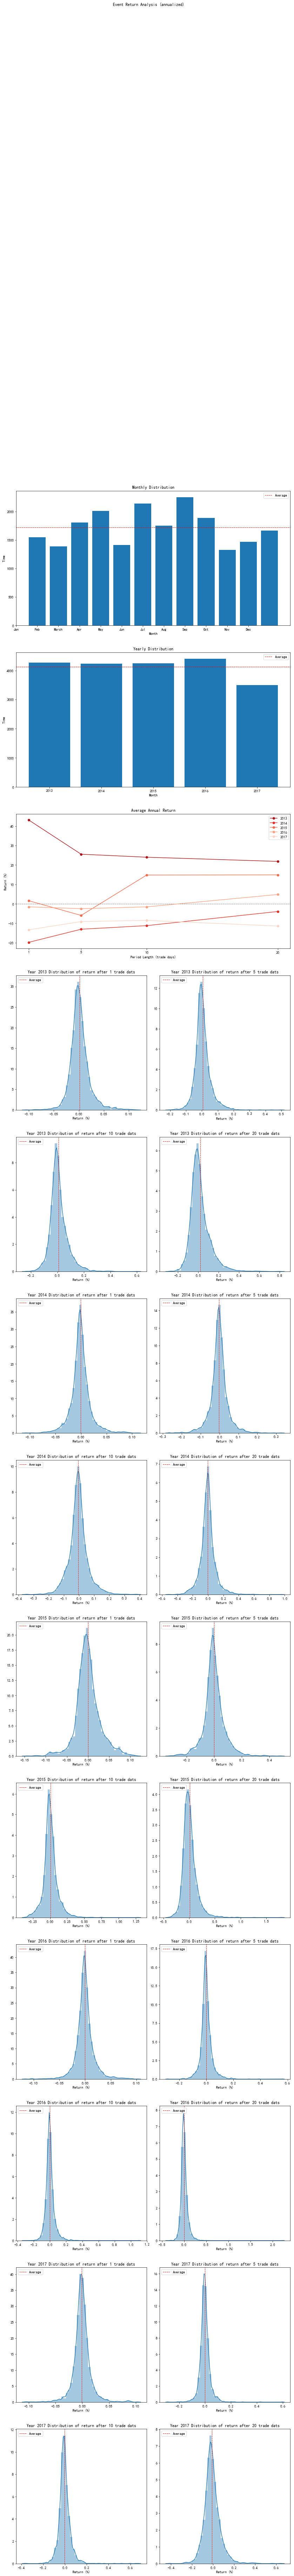

In [8]:
signal = dv.get_ts('dark_cross').shift(1, axis=0)  # avoid look-ahead bias
obj = SignalDigger(output_folder='technical_analysis', output_format='plot')
df_all, df_events, df_stats = obj.create_binary_event_report(signal, price, mask_all, price_bench,
                                                             periods=[1, 5, 10, 20], group_by='year')

In [14]:
df_stats

Annu. Ret.  Annu. Vol.     t-stat  p-value  skewness  \
trade_date Period                                                         
2013       1         0.431911    0.304468   5.951129  0.00000  0.863233   
           5         0.255724    0.336366   7.131663  0.00000  1.234761   
           10        0.240287    0.325843   9.782886  0.00000  1.276321   
           20        0.218682    0.336278  12.200415  0.00000  1.685340   
2014       1        -0.197957    0.297854  -2.780268  0.00546  0.414293   
           5        -0.130491    0.318864  -3.828076  0.00013  0.116261   
           10       -0.111930    0.314350  -4.710325  0.00000  0.376799   
           20       -0.039144    0.344931  -2.123092  0.03380  0.740924   
2015       1         0.016301    0.439435   0.154424  0.87728  0.177362   
           5        -0.059353    0.509061  -1.085339  0.27783  0.387951   
           10        0.148517    0.512236   3.816921  0.00014  1.129288   
           20        0.149293    0.467672   5.943187  0.00000  2.036057   
2016       1        -0.015321    0.272705  -0.240970  0.80959  0.348465   
           5        -0.024610    0.285690  -0.826180  0.40875  1.326001   
           10       -0.015360    0.268784  -0.775078  0.43833  2.723525   
           20        0.048424    0.276238   3.362507  0.00078  5.757381   
2017       1        -0.133403    0.253752  -1.902731  0.05717  0.378983   
           5        -0.091111    0.271095  -2.719924  0.00657  1.752072   
           10       -0.085047    0.270999  -3.591813  0.00033  2.206090   
           20       -0.113978    0.266814  -6.914292  0.00000  1.075634   

                     kurtosis  occurance  Annu. Ret. (all samp)  \
trade_date Period                                                 
2013       1         4.539431       4259               0.221098   
           5         7.358648       4259               0.227761   
           10        5.161412       4259               0.226922   
           20        6.440672       4259               0.248098   
2014       1         4.290580       4235              -0.029659   
           5         4.661303       4235              -0.020600   
           10        3.435171       4235              -0.021351   
           20        5.948578       4235              -0.014864   
2015       1         2.122781       4194               0.262930   
           5         3.567452       4194               0.282479   
           10        9.062777       4194               0.290308   
           20       13.460563       4194               0.268220   
2016       1         5.966286       4452               0.024100   
           5        14.006789       4452               0.029874   
           10       41.007718       4452               0.027080   
           20      142.106737       4452               0.019304   
2017       1         7.528036       3170              -0.079520   
           5        26.525608       3170              -0.083913   
           10       24.504641       3170              -0.087903   
           20        5.893220       3170              -0.096132   

                   Annu. Vol. (all samp)  
trade_date Period                         
2013       1                    0.326806  
           5                    0.348607  
           10                   0.359221  
           20                   0.378126  
2014       1                    0.319842  
           5                    0.353599  
           10                   0.374959  
           20                   0.416524  
2015       1                    0.473657  
           5                    0.521890  
           10                   0.542473  
           20                   0.561710  
2016       1                    0.277896  
           5                    0.282580  
           10                   0.272384  
           20                   0.268081  
2017       1                    0.255855  
           5                    0.270735  
           10                   0

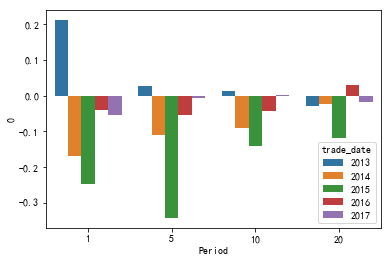

In [15]:
# 以等权收益作为基准，计算超额收益
sns.barplot(x='Period', y=0, hue='trade_date',
            data=(df_stats['Annu. Ret.'] - df_stats['Annu. Ret. (all samp)']).reset_index())

### 2.3 分析金叉信号

Nan Data Count (should be zero) : 0;  Percentage of effective data: 95%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 94%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 94%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 93%

       Calendar Distribution    (20412 occurance from 2013-01-04 to 2017-10-31):


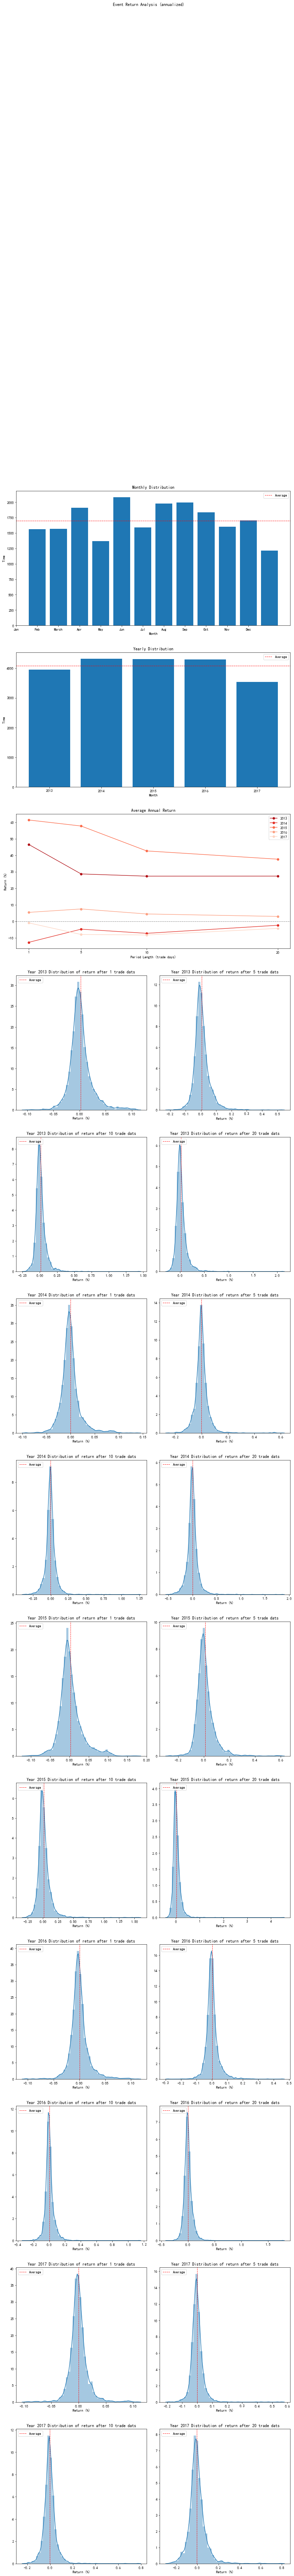

In [16]:
signal = dv.get_ts('golden_cross')  # avoid look-ahead bias
obj = SignalDigger(output_folder=dataview_folder, output_format='plot')
df_all, df_events, df_stats = obj.create_binary_event_report(signal, price, mask_all, price_bench,
                                                             periods=[1, 5, 10, 20], group_by='year')

In [17]:
df_stats

Annu. Ret.  Annu. Vol.     t-stat  p-value  skewness  \
trade_date Period                                                         
2013       1         0.465681    0.332783   5.630565  0.00000  1.081418   
           5         0.286797    0.347428   7.427104  0.00000  1.645409   
           10        0.273385    0.364200   9.551215  0.00000  3.350906   
           20        0.273713    0.374318  13.158124  0.00000  3.657600   
2014       1        -0.127562    0.316360  -1.703034  0.08863  1.339619   
           5        -0.047716    0.369742  -1.218803  0.22299  2.761665   
           10       -0.072975    0.382257  -2.549767  0.01081  2.708635   
           20       -0.024070    0.427762  -1.062857  0.28791  2.960887   
2015       1         0.613718    0.453817   5.724342  0.00000  1.002265   
           5         0.577183    0.485820  11.245019  0.00000  2.096017   
           10        0.426262    0.524027  10.888299  0.00000  4.167131   
           20        0.376194    0.551200  12.919765  0.00000  6.936304   
2016       1         0.053992    0.279384   0.811114  0.41735  1.038041   
           5         0.074681    0.283559   2.471716  0.01349  1.510407   
           10        0.044318    0.279515   2.104359  0.03541  2.589078   
           20        0.029445    0.270247   2.045114  0.04090  3.436372   
2017       1        -0.009604    0.262063  -0.133216  0.89403  0.744871   
           5        -0.079960    0.280394  -2.318049  0.02051  3.117956   
           10       -0.082814    0.262863  -3.621661  0.00030  2.203200   
           20       -0.043108    0.267819  -2.616781  0.00892  1.610204   

                     kurtosis  occurance  Annu. Ret. (all samp)  \
trade_date Period                                                 
2013       1         4.224106       3918               0.230727   
           5         9.089560       3918               0.228886   
           10       42.113411       3918               0.227984   
           20       43.524154       3918               0.246103   
2014       1         5.498984       4317              -0.029454   
           5        27.209933       4317              -0.020525   
           10       34.758777       4317              -0.021219   
           20       34.174427       4317              -0.014811   
2015       1         2.776318       4336               0.262770   
           5        11.515845       4336               0.282524   
           10       44.208847       4336               0.290300   
           20      156.295495       4336               0.268132   
2016       1         6.472510       4263               0.024829   
           5        10.782758       4263               0.029890   
           10       41.004178       4263               0.026966   
           20       65.384658       4263               0.019169   
2017       1         7.792138       3198              -0.079821   
           5        36.272000       3198              -0.083771   
           10       25.084349       3198              -0.087663   
           20       10.814747       3198              -0.095962   

                   Annu. Vol. (all samp)  
trade_date Period                         
2013       1                    0.326892  
           5                    0.348463  
           10                   0.358971  
           20                   0.377986  
2014       1                    0.319859  
           5                    0.353595  
           10                   0.375020  
           20                   0.416533  
2015       1                    0.473667  
           5                    0.522029  
           10                   0.542474  
           20                   0.561693  
2016       1                    0.278017  
           5                    0.282600  
           10                   0.272409  
           20                   0.268117  
2017       1                    0.255868  
           5                    0.270759  
           10                   0

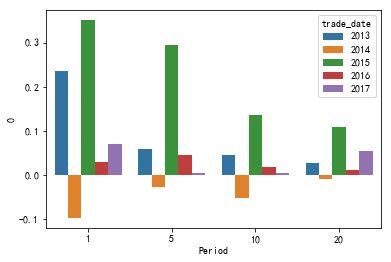

In [18]:
# 以等权收益作为基准，计算超额收益
sns.barplot(x='Period', y=0, hue='trade_date',
            data=(df_stats['Annu. Ret.'] - df_stats['Annu. Ret. (all samp)']).reset_index())

## 3. 技术指标二：三根阳线改变预期

### 3.1 定义三根阳线，并通过add_formula加入dataview中

In [19]:
# 定义单根阳线
formula = '(close_adj > open_adj) && ( ( (close_adj - open_adj)/(high_adj - low_adj) ) >= 0.7)'
dv.add_formula('UP', formula, is_quarterly = False)
# 定义三根阳线
formula = 'UP && Delay(UP, 1) && Delay(UP, 2)'
dv.add_formula('UP3', formula, is_quarterly = False)

/home/bliu/pytrade_dir/jaqs/jaqs/data/py_expression_eval.py:438: RuntimeWarning: invalid value encountered in greater_equal
  res = arr >= brr


### 3.2 分析三根阳线信号

Nan Data Count (should be zero) : 0;  Percentage of effective data: 88%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 88%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 88%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 87%

       Calendar Distribution    (309 occurance from 2013-01-04 to 2017-10-31):


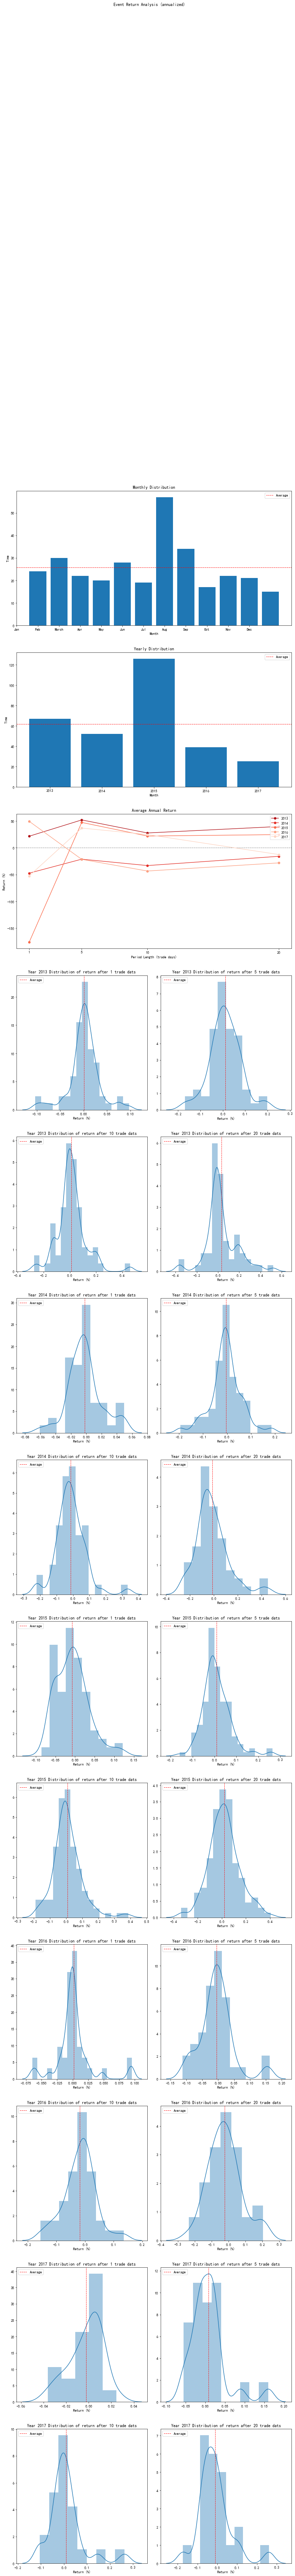

In [20]:
signal = dv.get_ts('UP3')  # avoid look-ahead bias
price = dv.get_ts('close_adj')
obj = SignalDigger(output_folder=dataview_folder, output_format='plot')
df_all, df_events, df_stats = obj.create_binary_event_report(signal, price, mask_all, price_bench,
                                                             periods=[1, 5, 10, 20], group_by='year')

In [22]:
df_stats

Annu. Ret.  Annu. Vol.    t-stat  p-value  skewness  \
trade_date Period                                                        
2013       1         0.216291    0.518770  0.219378  0.82703 -0.406349   
           5         0.520887    0.476937  1.284985  0.20329  0.068674   
           10        0.277396    0.539248  0.855937  0.39513  0.811499   
           20        0.397910    0.518748  1.804985  0.07564  0.540430   
2014       1        -0.472821    0.347772 -0.630226  0.53136  0.274539   
           5        -0.211921    0.451843 -0.486145  0.62895 -0.067330   
           10       -0.331372    0.436400 -1.113076  0.27089  0.873533   
           20       -0.158481    0.483569 -0.679404  0.49995  1.130661   
2015       1        -1.763421    0.637730 -1.995249  0.04819  0.734650   
           5         0.473950    0.443474  1.724359  0.08712  1.070848   
           10        0.219847    0.437185  1.147446  0.25339  1.091164   
           20        0.246804    0.444171  1.793059  0.07538  0.231930   
2016       1         0.495147    0.457194  0.434768  0.66619  1.119556   
           5        -0.215494    0.375644 -0.514953  0.60957  0.864039   
           10       -0.433223    0.277891 -1.979071  0.05509 -0.028992   
           20       -0.281289    0.340416 -1.483483  0.14619  0.479084   
2017       1        -0.525627    0.231782 -0.699124  0.49180 -0.622823   
           5         0.368633    0.316764  0.802230  0.43100  1.687176   
           10        0.248049    0.374244  0.646157  0.52486  1.643399   
           20       -0.125657    0.294931 -0.587407  0.56291  1.307604   

                   kurtosis  occurance  Annu. Ret. (all samp)  \
trade_date Period                                               
2013       1       2.384101         67               0.209308   
           5       0.971010         67               0.205721   
           10      3.518563         67               0.205245   
           20      1.895020         67               0.223413   
2014       1       0.705842         52              -0.046433   
           5       1.456912         52              -0.041671   
           10      3.545167         52              -0.045800   
           20      2.110555         52              -0.038017   
2015       1       0.654321        126               0.175297   
           5       2.931903        126               0.197231   
           10      3.334981        126               0.214306   
           20      0.578917        126               0.202778   
2016       1       3.765123         39               0.028265   
           5       2.162931         39               0.034628   
           10      0.798924         39               0.031997   
           20      0.331553         39               0.023885   
2017       1      -0.216591         23              -0.069902   
           5       3.801464         23              -0.068814   
           10      3.866385         23              -0.071089   
           20      3.008400         23              -0.079894   

                   Annu. Vol. (all samp)  
trade_date Period                         
2013       1                    0.322748  
           5                    0.333511  
           10                   0.333853  
           20                   0.342469  
2014       1                    0.315381  
           5                    0.331836  
           10                   0.339684  
           20                   0.369050  
2015       1                    0.455356  
           5                    0.478392  
           10                   0.478727  
           20                   0.466267  
2016       1                    0.274076  
           5                    0.274786  
           10                   0.261403  
           20                   0.251314  
2017       1                    0.255791  
           5                    0.268503  
           10                   0.269880  
           20                   0.277239

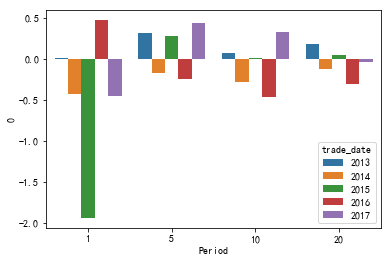

In [23]:
# 以等权收益作为基准，计算超额收益
sns.barplot(x='Period', y=0, hue='trade_date',
            data=(df_stats['Annu. Ret.'] - df_stats['Annu. Ret. (all samp)']).reset_index())

## 4. 技术指标三：跳空高开 / 低开

### 4.1 定义为今开减昨收，并通过add_formula加入dataview中

In [16]:
# 定义跳空高开
formula = 'open_adj / Delay(close_adj, 1)'
dv.add_formula('open_jump', formula, is_quarterly=False) # good

### 4.2 分析跳空高开信号 

Nan Data Count (should be zero) : 0;  Percentage of effective data: 94%


Value of signals of Different Quantiles Statistics
               min       max      mean       std   count    count %
quantile                                                           
1         0.897436  1.080865  0.989254  0.012890  109644  20.085108
2         0.900000  1.097622  0.996365  0.008225  109103  19.986005
3         0.900223  1.099841  0.998926  0.007471  109183  20.000659
4         0.913883  1.100051  1.001379  0.006805  109103  19.986005
5         0.951691  1.102128  1.010228  0.016387  108864  19.942224
Information Analysis
                ic
IC Mean      0.006
IC Std.      0.121
t-stat(IC)   1.607
p-value(IC)  0.108
IC Skew      0.054
IC Kurtosis  2.041
Ann. IR      0.047


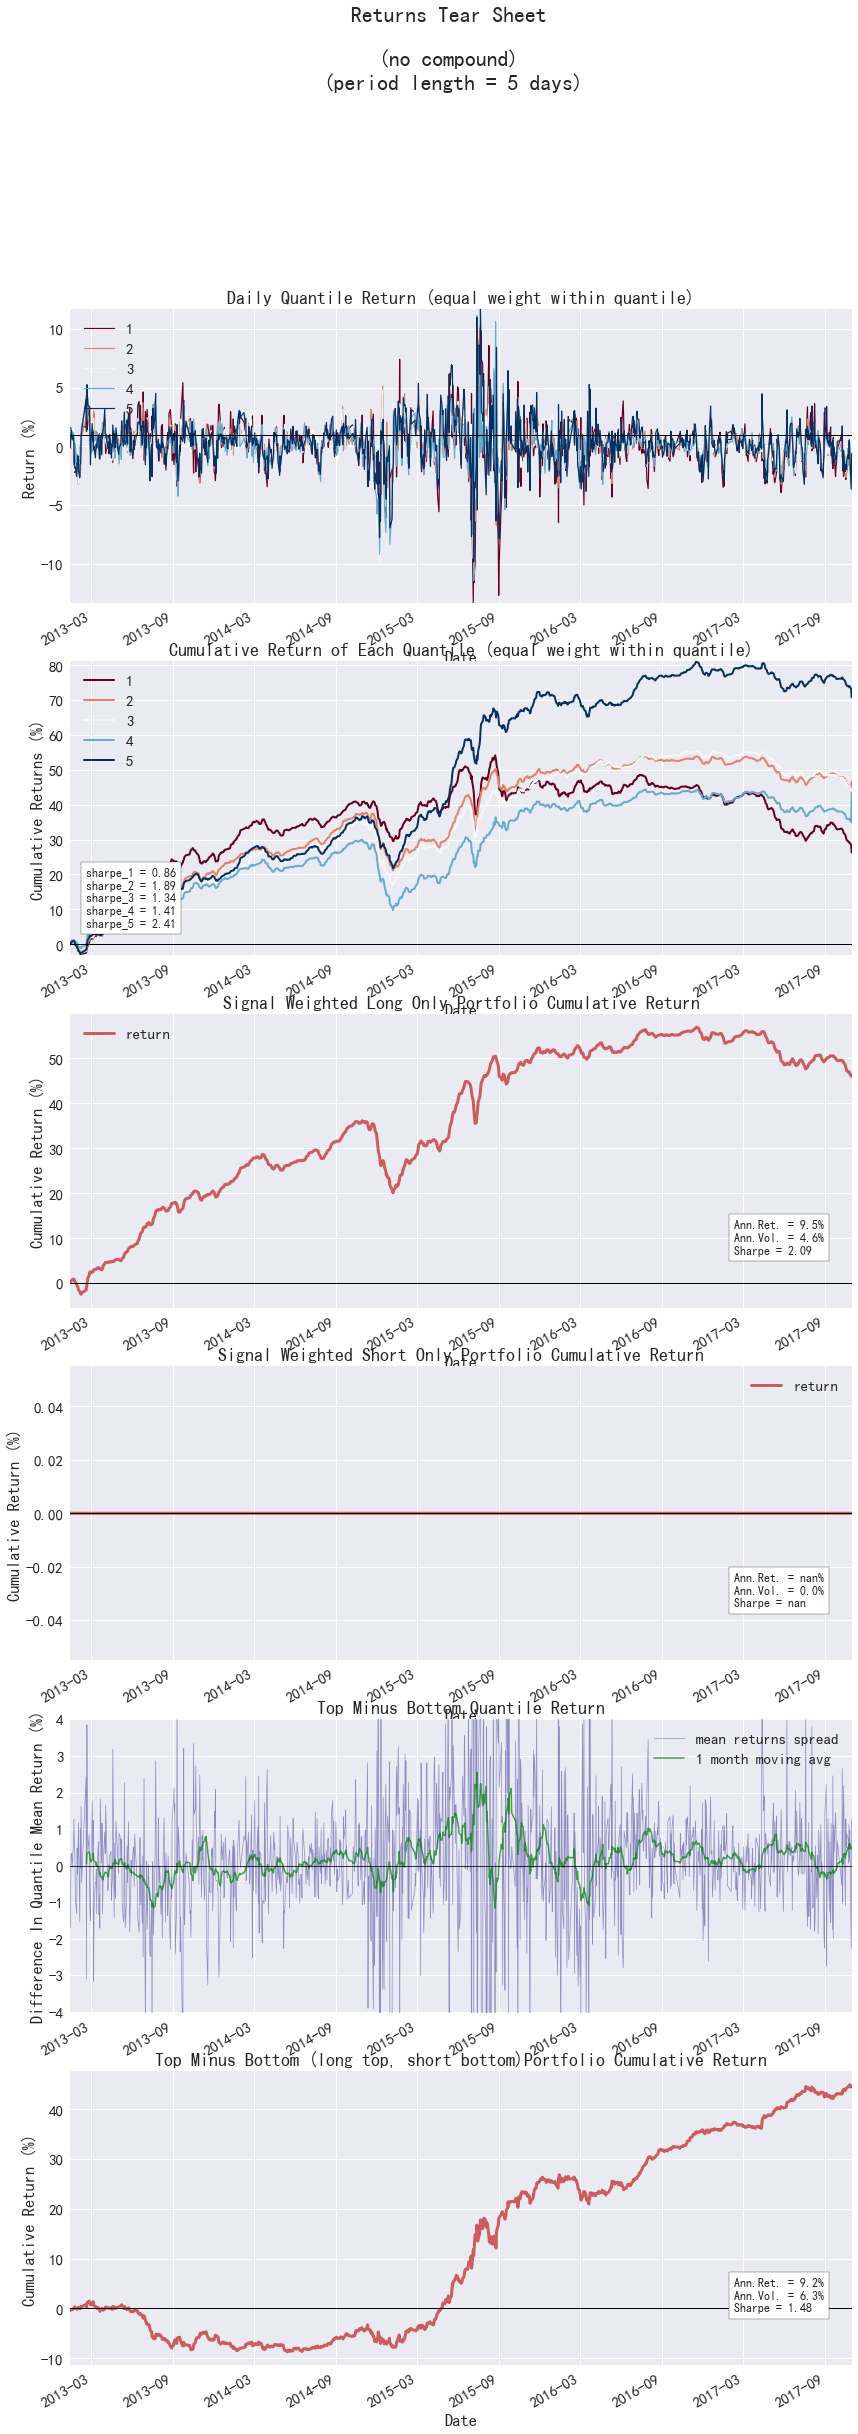

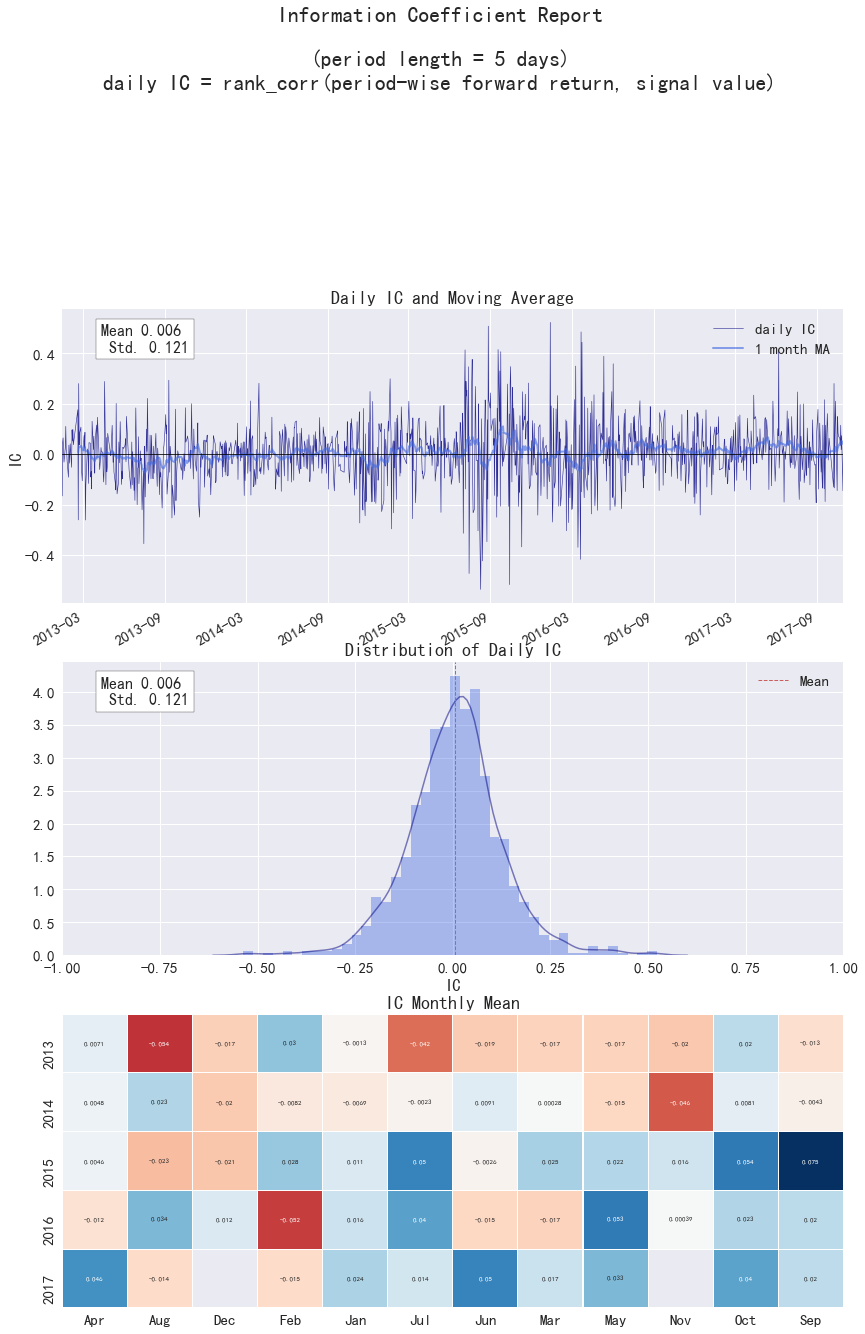

In [17]:
signal = dv.get_ts('open_jump')  # avoid look-ahead bias
my_period = 5  # 5日调仓，一年10% cost，因而10%一下收益无法战胜成本

obj = SignalDigger(output_folder=dataview_folder, output_format='plot')
obj.process_signal_before_analysis(signal, price=price,
                                   mask=mask_all,
                                   n_quantiles=5, period=my_period,
                                   benchmark_price=price_bench,
                                   )
res = obj.create_full_report()

#没有纯空头收益，因为信号总是正的